<a href="https://colab.research.google.com/github/sua-xesu/TCD_OpenQuantumSystem/blob/main/v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural networks**

---


In this tutorial, neural network is used to demonstrate how to use deep learning to predict the energy of a specific configuration of the water molecule. In Keras, there are a number of hyperparameters that can be customize and that affects the performance of your model significantly. We willl explore some of these hyperparameters in this tutorial.

For this tutorial, you are provided with:
1. ``H2O_unrotated.xyz`` and ``H2O_unrotated.ener``: a data set of 1750 configurations of the water molecule with random distortions. All molecules in this set are oriented in the same direction.
2. ``H2O_rotated.xyz`` and ``H2O_rotated.ener``: a data set of 1750 configurations of the water molecule with random distortions, rotations, and translations. Molecules in this set are not oriented in the same direction.

The goal is to have a machine learning model that is capable of predicting the energy of each configurations. This tutorial provides a guide for you to build your own model that can achieve this goal for both data sets.

*(You can run this file to see what the commands do but please **do not** try to modify this file directly here. Your edits will not be saved. Make a copy in your Drive under the File tab in order to edit it.)*

## Building the model

*(If you run this in Google Colab, you need to upload the data files to the content folder and modify the file path accordingly. If you run this on Jupyter Notebook, you need to put the data files and this code file in the same folder.)*

Our model needs to take molecular structure information as input and predict the energy based on this information.

In [1]:
# import necessary libraries
%pip install ase
from ase.io import read
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.4 MB/s eta 0:00:00


In [3]:
file_path="/content/H2O_unrotated.xyz"
ftrs=read(file_path,':')
nsample=len(ftrs)                                                   
natom=[ftrs[i].get_number_of_atoms() for i in range(nsample)]
coords=np.array([ftrs[i].get_positions() for i in range(nsample)])
all_labels=[ftrs[i].get_chemical_symbols() for i in range(nsample)]

file_path="/content/H2O_rotated.xyz"
ftrs=read(file_path,':')
rotated_nsample=len(ftrs)                                                   
rotated_natom=[ftrs[i].get_number_of_atoms() for i in range(rotated_nsample)]
rotated_coords=np.array([ftrs[i].get_positions() for i in range(rotated_nsample)])
rotated_all_labels=[ftrs[i].get_chemical_symbols() for i in range(rotated_nsample)]

file_path="/content/H2O_test.xyz"
ftrs=read(file_path,':')
test_nsample=len(ftrs) 
test_natom=[ftrs[i].get_number_of_atoms() for i in range(test_nsample)]
test_coords=np.array([ftrs[i].get_positions() for i in range(test_nsample)])
test_all_labels=[ftrs[i].get_chemical_symbols() for i in range(test_nsample)]

distance_unrotated=np.zeros((nsample,1,3))
for i in range(nsample):
    d0=np.sqrt(np.sum((coords[i,0,:]-coords[i,1,:])**2))
    d1=np.sqrt(np.sum((coords[i,1,:]-coords[i,2,:])**2))
    d2=np.sqrt(np.sum((coords[i,0,:]-coords[i,2,:])**2))
    distance_unrotated[i][0][0]=d0
    distance_unrotated[i][0][1]=d1
    distance_unrotated[i][0][2]=d2
#print(distance_unrotated.shape)

distance_rotated=np.zeros((rotated_nsample,1,3))
for i in range(rotated_nsample):
    d0=np.sqrt(np.sum((rotated_coords[i,0,:]-rotated_coords[i,1,:])**2))
    d1=np.sqrt(np.sum((rotated_coords[i,1,:]-rotated_coords[i,2,:])**2))
    d2=np.sqrt(np.sum((rotated_coords[i,0,:]-rotated_coords[i,2,:])**2))
    distance_rotated[i][0][0]=d0
    distance_rotated[i][0][1]=d1
    distance_rotated[i][0][2]=d2
#print(distance_rotated)

distance_test=np.zeros((test_nsample,1,3))
for i in range(test_nsample):
    d0=np.sqrt(np.sum((test_coords[i,0,:]-test_coords[i,1,:])**2))
    d1=np.sqrt(np.sum((test_coords[i,1,:]-test_coords[i,2,:])**2))
    d2=np.sqrt(np.sum((test_coords[i,0,:]-test_coords[i,2,:])**2))
    distance_test[i][0][0]=d0
    distance_test[i][0][1]=d1
    distance_test[i][0][2]=d2
#print(distance_test)

# read the corresponding energy values
ener=np.loadtxt("/content/H2O_unrotated.ener")
rotated_ener=np.loadtxt("/content/H2O_rotated.ener")
test_ener=np.loadtxt("/content/H2O_test.ener")

/usr/local/lib/python3.9/dist-packages/ase/atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


For neural network, as the method is numerical, we should normalize our input and output for better accuracy.
$$
x_i'=\frac{x_i - \bar{x}}{x_{max} - x_{min}}
$$

In [4]:
#normalize inputs
unrotated_norm_coords=np.zeros((distance_unrotated.shape))
for i in range(3):
  unrotated_norm_coords[:,0,i]=(distance_unrotated[:,0,i]-np.mean(distance_unrotated[:,0,i]))/(np.max(distance_unrotated[:,0,i])-np.min(distance_rotated[:,0,i])) 

rotated_norm_coords=np.zeros((distance_rotated.shape))
for j in range(3):
  rotated_norm_coords[:,0,j]=(distance_rotated[:,0,j]-np.mean(distance_rotated[:,0,j]))/(np.max(distance_rotated[:,0,j])-np.min(distance_rotated[:,0,j]))

test_norm_coords=np.zeros((distance_test.shape))
for k in range(3):
  test_norm_coords[:,0,k]=(distance_test[:,0,k]-np.mean(distance_test[:,0,k]))/(np.max(distance_test[:,0,k])-np.min(distance_test[:,0,k]))

#normalize outputs
norm_E = (ener - np.mean(ener))/(np.max(ener)-np.min(ener))
rotated_norm_E = (rotated_ener - np.mean(rotated_ener))/(np.max(rotated_ener)-np.min(rotated_ener))
test_norm_E = (test_ener - np.mean(test_ener))/(np.max(test_ener)-np.min(test_ener))

First, we build a model with customizable parameters to make our codes short and neat. There are 2 basic ways to build a model in Keras, through the Sequential API and Functional API. Sequential models are straightforward and easy to create by building it layer by layer, but are not flexible (not allowing multiple inputs and outputs, no layer sharings, etc.) On the other hand, the Functional API is more flexible and powerful, allowing different customizations. In this tutorial, for the sake of simplicity, we will use the Sequential API and the `add()` method.

You can test if the model architecture is as desired. In the table of this output, the layers are listed from input, hidden layers, and lastly, output layer. Each layer has its own output shape and the number of parameters that will be learned during the training process. The total number of parameters, trainable parameters, and non-trainable parameters are printed below the table.

In [5]:
# build and compile the model
def build_compile_model(natom, reg, learn_rate):
    model = keras.Sequential()
    #specify an input layer with the number of nodes = the number of relative distances
    #model.add(layers.Input(shape=(natom,3)))

    #flatten the 2D input array into a 1D array, you can also do this with numpy .flatten()
    model.add(layers.Flatten(input_shape=(1,3)))

    #add hidden layers
    model.add(layers.Dense(32, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))
    model.add(layers.Dense(16, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))
    model.add(layers.Dense(8, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))

    #finally, add an output layer
    model.add(layers.Dense(1, use_bias=False,kernel_regularizer=keras.regularizers.l2(reg)))

    # define the optimizer: Adam is a gradient descent algorithm 
    opt=keras.optimizers.Adam(learning_rate=learn_rate)

    #compile the model
    model.compile(loss='mse',optimizer=opt)

    return model

model = build_compile_model(3, 1e-3, 0.001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


The model is now ready to be trained. The data set is randomly divided here into the training set (with 1250 configurations), the validation set (with 250 configurations), and the test set (with 250 configurations). The validation set will mainly be used in the later sections to optimize the hyperparameters. The test set contains configurations your model has never seen and is used to test the generalizability of the model and its RMSE.

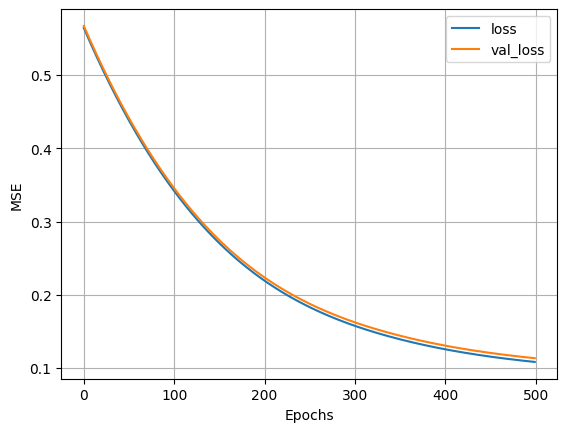

In [14]:
idx=np.arange(nsample)
np.random.shuffle(idx)
#tr_coords=norm_coords[idx[:1250],:,:]
tr_unrotated_distance=distance_unrotated[idx[:1500],:,:]
tr_rotated_distance=distance_rotated[idx[:1500],:,:]
tr_distance = tr_unrotated_distance+tr_rotated_distance

tr_unrotated_E=norm_E[idx[:1500]]
tr_rotated_E=rotated_norm_E[idx[:1500]]
tr_E=tr_unrotated_E+tr_rotated_E
#va_coords=norm_coords[idx[1250:1500],:,:]
va_unrotated_distance=distance_unrotated[idx[1500:],:,:]
va_rotated_distance=distance_rotated[idx[1500:],:,:]
va_distance=va_unrotated_distance+va_rotated_distance

va_unrotated_E=norm_E[idx[1500:]]
va_rotated_E=rotated_norm_E[idx[1500:]]
va_E=va_unrotated_E+va_rotated_E
#te_coords=norm_coords[idx[1500:],:,:]

idx=np.arange(test_nsample)
np.random.shuffle(idx)
te_distance=distance_test[idx[:]]
te_E=test_ener


history=model.fit(tr_distance,tr_E,epochs=500,validation_data=(va_distance,va_E),verbose=0)

# plot a learning curve of loss of the training and validation set vs the number of epochs the model is trained
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 1ms/step
The model's RMSE is:  76.37627213117366


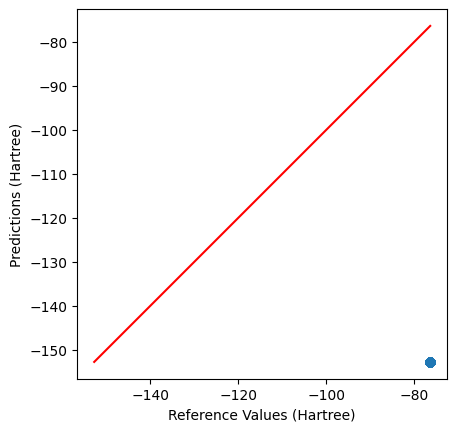

In [15]:
norm_predict=model.predict(te_distance)
predict=norm_predict*(np.max(ener+rotated_ener) - np.min(ener+rotated_ener))+np.mean(ener+rotated_ener)
rmse = np.sqrt(np.mean((predict-te_E)**2))

print("The model's RMSE is: ", rmse)
#visualize the model's prediction vs the correct value
plt.axes(aspect='equal')
plt.scatter(te_E, predict)
plt.xlabel('Reference Values (Hartree)')
plt.ylabel('Predictions (Hartree)')
plt.plot([np.min([np.min(te_E),np.min(predict)]),np.max([np.max(te_E),np.max(predict)])], [np.min([np.min(te_E),np.min(predict)]),np.max([np.max(te_E),np.max(predict)])], 'r-')
plt.show()

## Effects of hyperparameters

Hyperparameters usually affect the performance of your model significantly. Therefore, it is important to optimize them. Two hyperparameters are optimized in the following sections but (of course) there are many more that can be explored. You are encouraged to play with the values of the hyperparameters.

1. Regularization

8/8 [==============================] - 0s 2ms/step


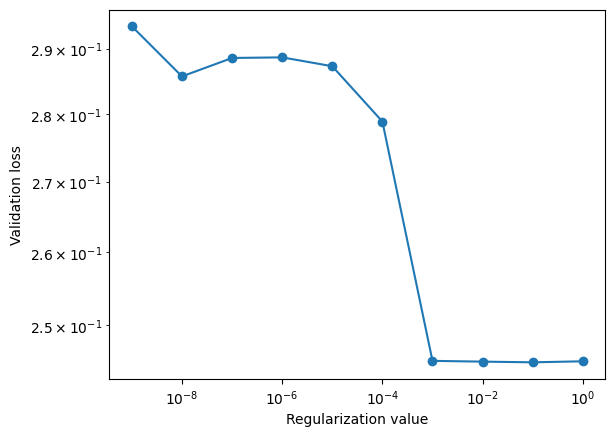

In [12]:
regularization=[1,0.1,0.01,0.001,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]
va_loss=[]
for r in range(len(regularization)):
  model = build_compile_model(3, regularization[r], 0.001)
  history = model.fit(tr_distance,tr_E,epochs=500,validation_data=(va_distance,va_E),verbose=0)
  va_predict=model.predict(va_distance)
  # get the RMSE of the model prediction for the validation set
  va_loss.append(np.sqrt(np.mean((va_predict-va_E)**2)))

#visualize the effects of different regularization values on the model's accuracy
plt.plot(regularization, va_loss, marker='o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Regularization value')
plt.ylabel('Validation loss')
plt.show()

# get the regularization value corresponding to the smallest validation error
for i in range(len(va_loss)):
    if va_loss[i]==min(va_loss):
        reg=regularization[i]


2. Learning rate

8/8 [==============================] - 0s 2ms/step


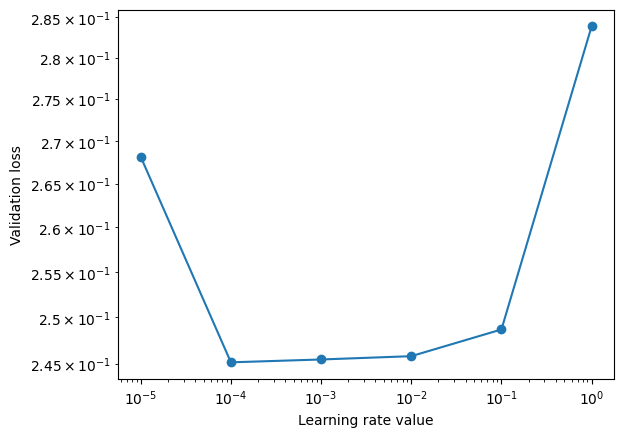

In [13]:
learning_rate=[1,0.1,0.01,0.001,0.0001,1e-5]
va_loss=[]
for lr in range(len(learning_rate)):
  model = build_compile_model(3, reg, learning_rate[lr])
  history = model.fit(tr_distance,tr_E,epochs=500,validation_data=(va_distance,va_E),verbose=0)
  va_predict=model.predict(va_distance)
  # get the RMSE of the model prediction for the validation set
  va_loss.append(np.sqrt(np.mean((va_predict-va_E)**2)))

#visualize the effects of different learning rate values on the model's accuracy
plt.plot(learning_rate, va_loss, marker='o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Learning rate value')
plt.ylabel('Validation loss')
plt.show()

# get the learning rate value corresponding to the smallest validation error
for i in range(len(va_loss)):
    if va_loss[i]==min(va_loss):
        learn_rate=learning_rate[i]